In [1]:
from toolz import valmap

import h5py
import pyharm

import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
from matplotlib import ticker, cm
import pyharm.plots.plot_dumps as pplt

from mpl_toolkits import mplot3d

In [2]:
i0 = 5010 # initial  frame
i1 = 5061 # 1 + last frame

fmt = 'torus.out0.{:05d}.h5'

qualities = ['RHO', 'Pg', 'bsq', 'beta', 'Theta', 'Thetae']

In [3]:
# some constants
cl = 29979245800.0 # speed of light in cgs
mp = 1.67262171e-24
kb = 1.3806505e-16
mu = 1.

In [4]:
def fname(i, src): # closure on `src` and `fmt`
    return (src+fmt).format(i)

In [5]:
src_ma_10M = '/xdisk/chanc/share/GRMHD_dt10M/Ma+0.94_w5/'
src_sa_10M = '/xdisk/chanc/share/GRMHD_dt10M/Sa+0.94_w5/'

src_ma_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Ma+0.94_w5/'
src_sa_1000M = '/xdisk/chanc/share/GRMHD_dt1000M/Sa+0.94_w5/'

dump0 = pyharm.load_dump(fname(i0, src_ma_10M))
R_low = 1.
R_high = [1, 10, 40, 160]
# first row of SANE model params

In [6]:
def get_dumps(i0, i1, src, step=1):
    dumps = {}
    for i in range(i0, i1, step):
        dumps[str(i)] = pyharm.load_dump(fname(i, src))
    return dumps

for later variance($\rho$|$P_{g}$|$P_{mag}$) calculations

In [7]:
def average(irange, dumps, keys):
    s = {k:0 for k in keys}
    for i in irange:
        # print('i:', i)
        # Because data I/O is expensive, we load the data once ...
        d = dumps[str(i)].cache
        # print('d:', d)
        # ... and then sum over multiple keys
        for k in keys:
            s[k] += d[k] # i.e.: s[key1] = file1[key1] + file2[key1] + file3[key1] + ...
            # print('s[k]:', s[k])
            # print('d[k]', d[k])
    print('finish average calculation.')
    return valmap(lambda v: v/len(irange), s) # return an average of variables from the files read in

In [8]:
# works; returns an array of arrays with numerical values
def variance(irange, dumps, quality='Te'):
    """
    quality: str, the physical quality whose variance values we want (e.g. 'Te' for electron temperature)
    dumps: dictionary, all the dump files read in
    """
    key = 'var' + quality
    ss = {key: 0}
    for i in irange:
        d = dumps[str(i)].cache
        ss[key] += (d[quality]-d['avg' + quality])**2
    for i in irange:
        dumps[str(i)].cache[key] = ss[key]
    print('finish variance & standard deviation calculation\'s loop.')
    # return valmap(lambda v: v/len(irange), ss)

$\gamma = \frac{4}{3}$, $x_{e} = \frac{1}{4}$, so ions:electrons = 3:1 (y=1, z=3; $\gamma_{i}=\gamma=\frac{4}{3}, \gamma_e = \gamma + x_{e} / (1 - x_{e})(5/3 - \gamma) = \frac{7}{3}$) <br> 
$Const = m_{p}(\gamma_{e}-1)(\gamma_{i}-1)$ <br> 
$const1 = y(\gamma_{i}-1)$ <br>
$const2 = z(\gamma_{e}-1)$ <br>
$const3 = k_{B}(\gamma-1)$

In [9]:
# constants used for the functions
y = 1.
z = 3.
gamma = 4/3
gamma_i = 4/3
gamma_e = 7/3
const = mp*(gamma_e - 1)*(gamma_i - 1)
const1 = y*(gamma_i - 1)
const2 = z*(gamma_e - 1)
const3 = kb*(gamma - 1)

$R=\frac{R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{R_{high}P_{g}^{2}}{P_{mag}^{2}+P_{g}^{2}}$

In [10]:
def R(dump, Rh, Rl, Pmag):
    Pg = dump['Pg']
    return Rl/(Pmag**2+Pg**2)+Rh*Pg**2/(Pmag**2+Pg**2)

The derived correlation functions: https://www.overleaf.com/project/648f4ef47315ccb8acbff565 <br>
For variance($\rho$): $F_{1}(\rho, P_{g}, P_{mag}) = -\frac{Const}{const3}\frac{P_{g}}{\rho^{2}\cdot k_{B}[const1+R\cdot const2]}$ <br>
For variance($P_{g}$): $F_{2}(P_{g}, P_{mag})= \frac{Const}{c3}[\frac{1}{c1+c2\cdot(\frac{P_{mag}^{2}R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{P_{g}^{2}R_{high}}{P_{mag}^{2}+P_{g}^{2}})}-\frac{c2P_{g}(\frac{2R_{high}P_{g}}{P_{mag}^{2}+P_{g}^{2}}-\frac{2R_{high}P_{g}^{3}}{(P_{mag}^{2}+P_{g}^{2})^{2}}-\frac{2R_{low}P_{g}}{(P_{mag}^{2}+P_{g}^2)^{2}})}{(c1+c2\cdot(\frac{P_{mag}^{2}R_{low}}{P_{mag}^{2}+P_{g}^{2}}+\frac{P_{g}^{2}R_{high}}{P_{mag}^{2}+P_{g}^{2}})^{2}}]$ <br>
For variance($P_{mag}$): $F_{3}(P_{g}, P_{mag}) = \frac{c2(R_{high}-R_{low})P_{g}^{2}}{[c1\cdot(P_{mag}^{2}+P_{g}^{2})+c2\cdot(P_{mag}^{2}R_{low}+P_{g}^{2}R_{high})]^{2}}$ 

In [11]:
# rho
def F1(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    frac = Pg/(rho**2*kb*(const1+r*const2))
    val = -const/const3*frac
    # dump.cache['F1'] = val
    dump.cache['coeff1'] = val**2

In [12]:
# Pg
def F2(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    frac1 = 1/(const1*(Pmag**2+Pg**2)+const2*(Pmag**2*Rl/(Pmag**2+Pg**2)+Pg**2*Rh/(Pmag**2+Pg**2)))
    numerator2 = const2*Pg*(2*Rh*Pg/(Pmag**2+Pg**2)-2*Rh*Pg**3/(Pmag**2+Pg**2)**2-2*Rl*Pg/(Pmag**2+Pg**2)**2)
    denom2 = const1+const2*(Pmag**2*Rl/(Pmag**2+Pg**2)+Pg**2*Rh/(Pmag**2+Pg**2))
    # dump.cache['F2'] = const/const3*(frac1-numerator2/denom2)
    val = const/const3*(frac1-numerator2/denom2)
    dump.cache['coeff2'] = val**2

In [13]:
# P_mag
def F3(dump, Rh, Rl):
    rho = dump['RHO']
    Pg = dump['Pg']
    B2 = dump['bsq']
    Pmag = B2/(2*mu)
    r = R(dump, Rh, Rl, Pmag)
    
    nume = 8*const*const2*const3*(Rh-Rl)*Pg**2
    denom = (const1+const2*r)**2*(4*Pmag**2+Pg**2)**2
    dump.cache['coeff3'] = (nume/denom)**2

Read in files:

In [14]:
# MAD
dumps_ma = get_dumps(i0, i1, src_ma_10M)

In [14]:
# SANE
dumps_sa = get_dumps(i0, i1, src_sa_10M)

## Contours

In [15]:
# assume this is x2x3
def twoD_contour(dumps, coeff, title, lower_lim=-1e9, upper_lim=1e9, idx=0):
    N = 128
    x = np.linspace(lower_lim, upper_lim, N)
    y = np.linspace(lower_lim, upper_lim, N)

    X, Y = np.meshgrid(x, y)
    # the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
    z1 = dumps[str(i0)].cache[coeff][idx]

    # fig,ax=plt.subplots(1,1)
    cp = axes[count].contourf(X, Y, z1)
    cbar = fig.colorbar(cp, ax=axes[count]) # Add a colorbar to a plot
    # axes[count].set_title(title)
    axes[count].set_xlabel('x3')
    axes[count].set_ylabel('x2')
    # plt.show()

In [15]:
def twoD_contour_x1x2(dumps, coeff, title, lower_lim=-1e9, upper_lim=1e9, idx=0):
    N = 128
    x = np.linspace(lower_lim, upper_lim, N)
    y = np.linspace(lower_lim, upper_lim, N)
    
    X, Y = np.meshgrid(x, y)
    # the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
    z1 = dumps[str(i0)].cache[coeff][idx][:, :, 0]

    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, z1)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    plt.show()

In [ ]:
def twoD_contour_x1x3(dumps, coeff, title, lower_lim=-1e9, upper_lim=1e9, idx=0):
    N = 128
    x = np.linspace(lower_lim, upper_lim, N)
    y = np.linspace(lower_lim, upper_lim, N)

    X, Y = np.meshgrid(x, y)
    # the [0] is used to retreive the first (128, 128) grid in the calculated coeff1 matrix
    z1 = dumps[str(i0)].cache[coeff][idx][:, 0, :]

    fig,ax=plt.subplots(1,1)
    cp = ax.contourf(X, Y, z1)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title(title)
    ax.set_xlabel('x1')
    ax.set_ylabel('x3')
    plt.show()

### MAD

In [16]:
for dump in dumps_ma.values():
    dump['RHO']

### $R_{high}$ = $R_{low}$ = 1

the contour tutorial: https://matplotlib.org/stable/gallery/images_contours_and_fields/contourf_log.html <br>
https://www.tutorialspoint.com/matplotlib/matplotlib_3d_contour_plot.htm <br>
https://matplotlib.org/stable/gallery/mplot3d/contour3d_3.html

$F_{1}$

In [18]:
for dump in dumps_ma.values():
    F1(dump, R_high[0], R_low)

In [19]:
rho_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff1'])

finish average calculation.


In [20]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_ma_coeff_avg.values())))

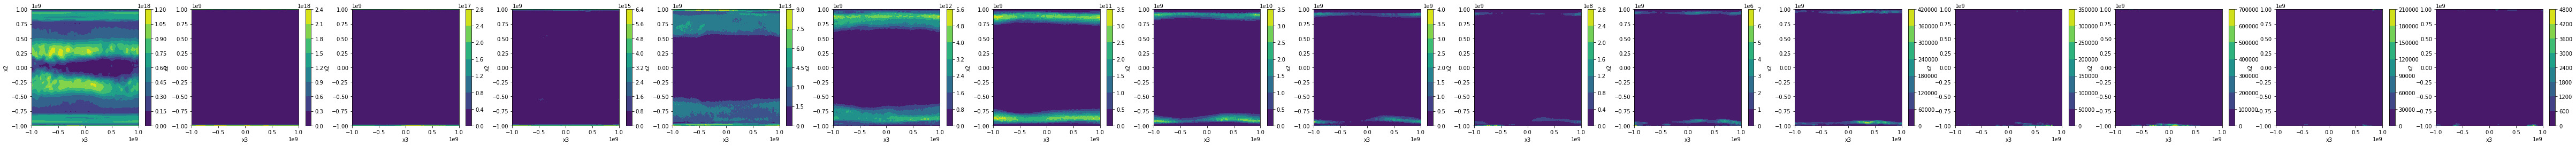

In [36]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_ma, 'avgcoeff1', 'Time Average 2D Contours Plot [MAD, Coeff(rho)]', idx=i)
    count +=1
fig.savefig('avg2D_MAD_Rh1_rho.png')

In [22]:
dumps_ma[str(i0)].cache['avgcoeff1'].shape

(288, 128, 128)

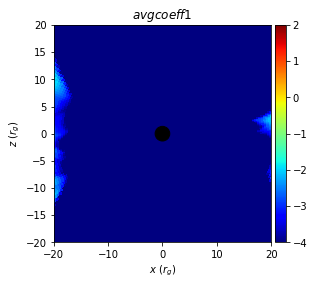

In [29]:
fig, ax = plt.subplots(1,1)
z1 = dumps_ma[str(i0)]
pplt.plot_xz(ax, z1, 'avgcoeff1', vmin=-4, vmax=2, window=(-20,20,-20,20), shading='flat')

In [20]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x2(dumps_ma, 'avgcoeff1', 'Time Average 2D Contours Plot [MAD, Coeff(rho)]', idx=i)
    plt.savefig('avg2D_MAD_Rh1_rho_x1x2'+ str(i)+'.png')

0


IndexError: too many indices for array

In [ ]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x3(dumps_ma, 'avgcoeff1', 'Time Average 2D Contours Plot [MAD, Coeff(rho)]', idx=i)
    plt.savefig('avg2D_MAD_Rh1_rho_x1x3'+ str(i)+'.png')

$F_{2}$

In [18]:
for dump in dumps_ma.values():
    F2(dump, R_high[0], R_low)

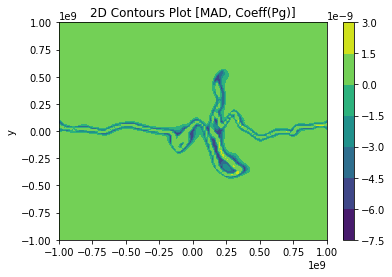

In [20]:
twoD_contour(dumps_ma, 'coeff2', '2D Contours Plot [MAD, Coeff(Pg)]')

In [19]:
Pg_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff2'])

finish average calculation.


In [20]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_ma_coeff_avg.values())))

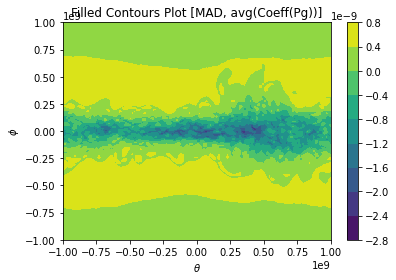

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]')

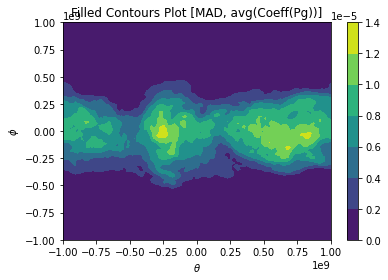

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]', idx=63)

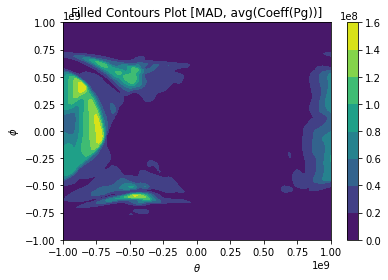

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]', idx=-1)

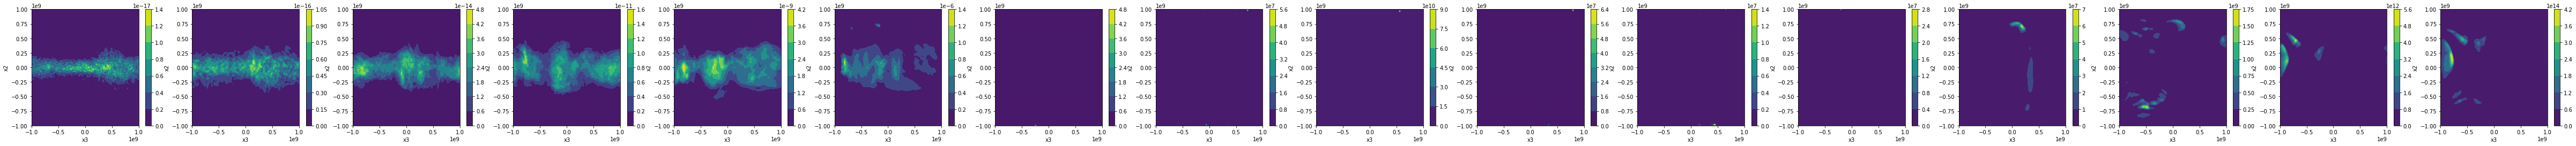

In [21]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_ma, 'avgcoeff2', 'Time Average 2D Contours Plot [MAD, Coeff(Pg)]', idx=i)
    count +=1
fig.savefig('avg2D_MAD_Rh1_Pg.png')

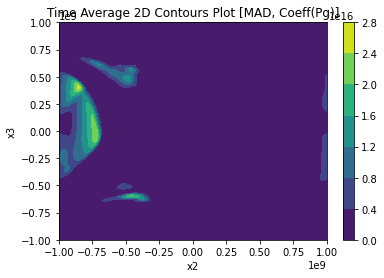

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Time Average 2D Contours Plot [MAD, Coeff(Pg)]', idx=287)
plt.savefig('avg2D_MAD_Rh1_Pg'+ str(287)+'.png')

In [ ]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x2(dumps_ma, 'avgcoeff2', 'Time Average 2D Contours Plot [MAD, Coeff(Pg)]', idx=i)
    plt.savefig('avg2D_MAD_Rh1_Pg_x1x2'+ str(i)+'.png')

In [ ]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x3(dumps_ma, 'avgcoeff2', 'Time Average 2D Contours Plot [MAD, Coeff(Pg)]', idx=i)
    plt.savefig('avg2D_MAD_Rh1_Pg_x1x3'+ str(i)+'.png')

$F_{3}$

$R_{high} = R_{low}$, so $F_{3}$ = 0

In [16]:
for dump in dumps_ma.values():
    F3(dump, R_high[0], R_low)

In [17]:
print(dumps_ma[str(i0)].cache['coeff3'][0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### $R_{high}$=160, $R_{low}$=1

$F_{1}$

In [18]:
for dump in dumps_ma.values():
    F1(dump, R_high[3], R_low)

In [19]:
print(dumps_ma[str(i0)].cache['coeff1'].shape)

(288, 128, 128)


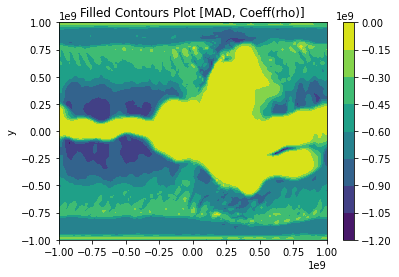

In [20]:
twoD_contour(dumps_ma, 'coeff1', 'Filled Contours Plot [MAD, Coeff(rho)]')

In [19]:
rho_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff1'])

finish average calculation.


In [20]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_ma_coeff_avg.values())))

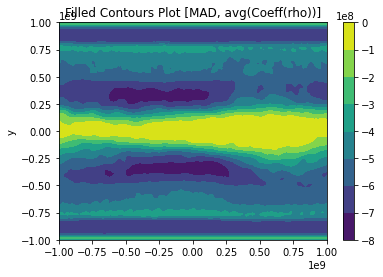

In [20]:
twoD_contour(dumps_ma, 'avgcoeff1', 'Filled Contours Plot [MAD, avg(Coeff(rho))]')

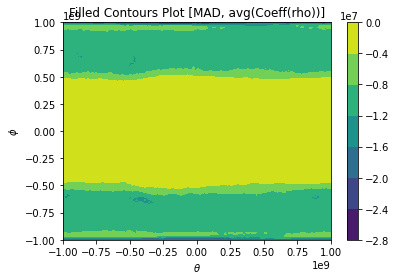

In [20]:
twoD_contour(dumps_ma, 'avgcoeff1', 'Filled Contours Plot [MAD, avg(Coeff(rho))]', idx=63)

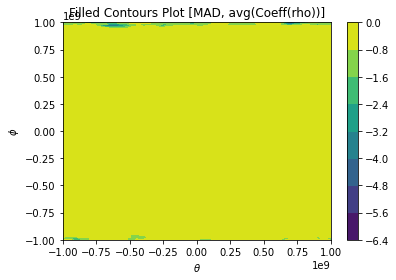

In [22]:
twoD_contour(dumps_ma, 'avgcoeff1', 'Filled Contours Plot [MAD, avg(Coeff(rho))]', idx=-1)

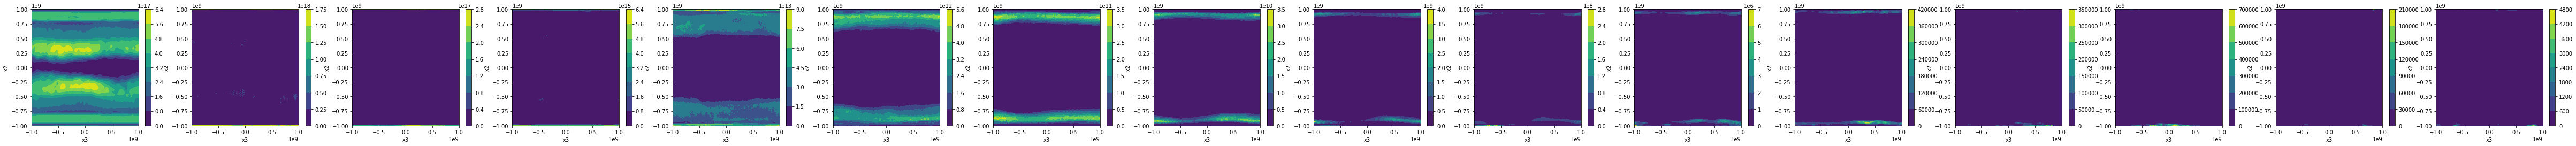

In [21]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_ma, 'avgcoeff1', 'Time Average 2D Contours Plot [MAD, Coeff(rho)]', idx=i)
    count +=1
fig.savefig('avg2D_MAD_Rh160_rho.png')

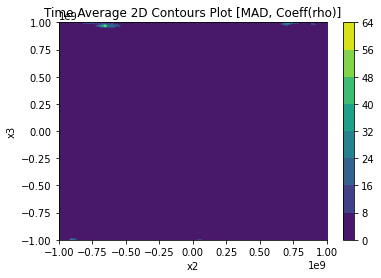

In [21]:
twoD_contour(dumps_ma, 'avgcoeff1', 'Time Average 2D Contours Plot [MAD, Coeff(rho)]', idx=287)
plt.savefig('avg2D_MAD_Rh160_rho'+ str(287)+'.png')

In [ ]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x2(dumps_ma, 'avgcoeff1', 'Time Average 2D Contours Plot [MAD, Coeff(rho)]', idx=i)
    plt.savefig('avg2D_MAD_Rh160_rho_x1x2'+ str(i)+'.png')

In [ ]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x3(dumps_ma, 'avgcoeff1', 'Time Average 2D Contours Plot [MAD, Coeff(rho)]', idx=i)
    plt.savefig('avg2D_MAD_Rh160_rho_x1x3'+ str(i)+'.png')

$F_{2}$

In [18]:
for dump in dumps_ma.values():
    F2(dump, R_high[3], R_low)

In [19]:
print(dumps_ma[str(i0)].cache['coeff2'][0])

[[2.11745250e-10 2.11585002e-10 2.11800973e-10 ... 2.12718824e-10
  2.12595850e-10 2.12170054e-10]
 [2.26586448e-10 2.27518587e-10 2.27672536e-10 ... 2.27015427e-10
  2.25695148e-10 2.25696738e-10]
 [2.58961508e-10 2.59376199e-10 2.59484699e-10 ... 2.56730798e-10
  2.57167936e-10 2.57954990e-10]
 ...
 [2.55281846e-10 2.53672351e-10 2.53815383e-10 ... 2.54812947e-10
  2.55513497e-10 2.56096864e-10]
 [2.30954343e-10 2.30653857e-10 2.31007327e-10 ... 2.30190073e-10
  2.30749363e-10 2.31291749e-10]
 [2.16493775e-10 2.17183127e-10 2.17859700e-10 ... 2.16664656e-10
  2.16555424e-10 2.16157569e-10]]


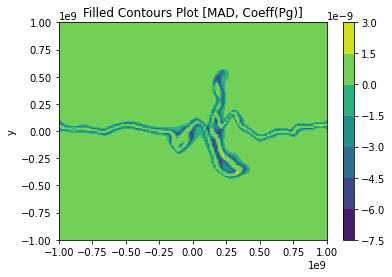

In [20]:
twoD_contour(dumps_ma, 'coeff2', 'Filled Contours Plot [MAD, Coeff(Pg)]')

In [19]:
Pg_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff2'])

finish average calculation.


In [20]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_ma_coeff_avg.values())))

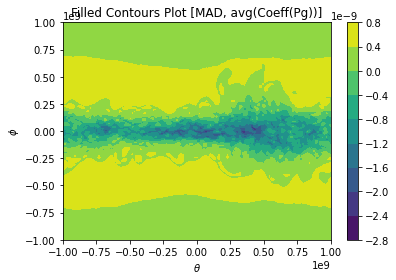

In [20]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]')

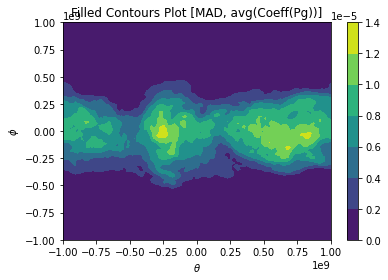

In [40]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]', idx=63)

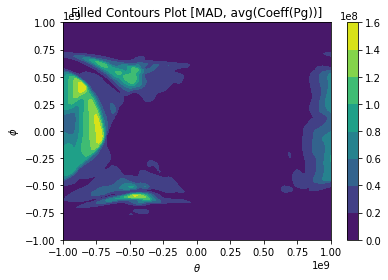

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Filled Contours Plot [MAD, avg(Coeff(Pg))]', idx=-1)

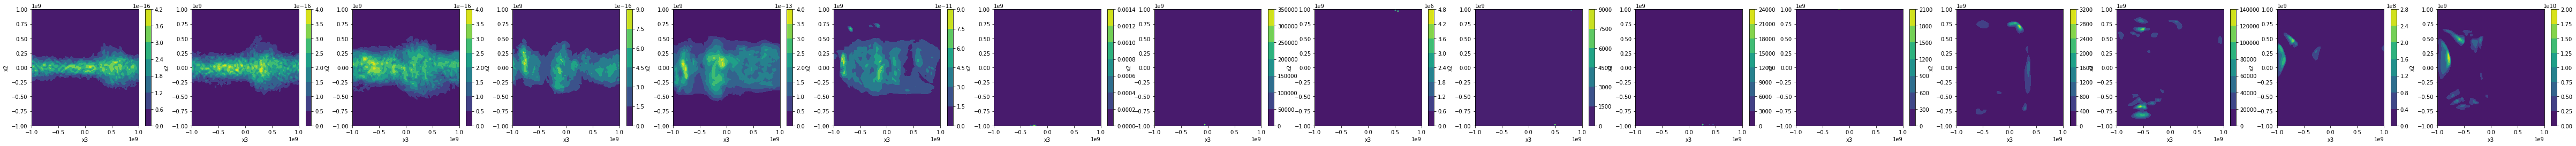

In [21]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_ma, 'avgcoeff2', 'Time Average 2D Contours Plot [MAD, Coeff(Pg)]', idx=i)
    count +=1
fig.savefig('avg2D_MAD_Rh160_Pg.png')

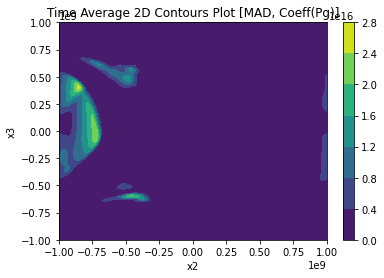

In [21]:
twoD_contour(dumps_ma, 'avgcoeff2', 'Time Average 2D Contours Plot [MAD, Coeff(Pg)]', idx=287)
plt.savefig('avg2D_MAD_Rh160_Pg'+ str(287)+'.png')

In [ ]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x2(dumps_ma, 'avgcoeff2', 'Time Average 2D Contours Plot [MAD, Coeff(Pg)]', idx=i)
    plt.savefig('avg2D_MAD_Rh160_Pg_x1x2'+ str(i)+'.png')

In [ ]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x3(dumps_ma, 'avgcoeff2', 'Time Average 2D Contours Plot [MAD, Coeff(Pg)]', idx=i)
    plt.savefig('avg2D_MAD_Rh160_Pg_x1x3'+ str(i)+'.png')

$F_{3}$

In [17]:
for dump in dumps_ma.values():
    F3(dump, R_high[3], R_low)

In [ ]:
twoD_contour(dumps_ma, 'coeff3', 'Filled Contours Plot [MAD, Coeff(Pg)]')

In [18]:
Pmag_ma_coeff_avg = average(range(i0, i1), dumps_ma, ['coeff3'])

finish average calculation.


In [19]:
for dump in dumps_ma.values():
    dump.cache['avgcoeff3'] = np.squeeze(np.array(list(Pmag_ma_coeff_avg.values())))

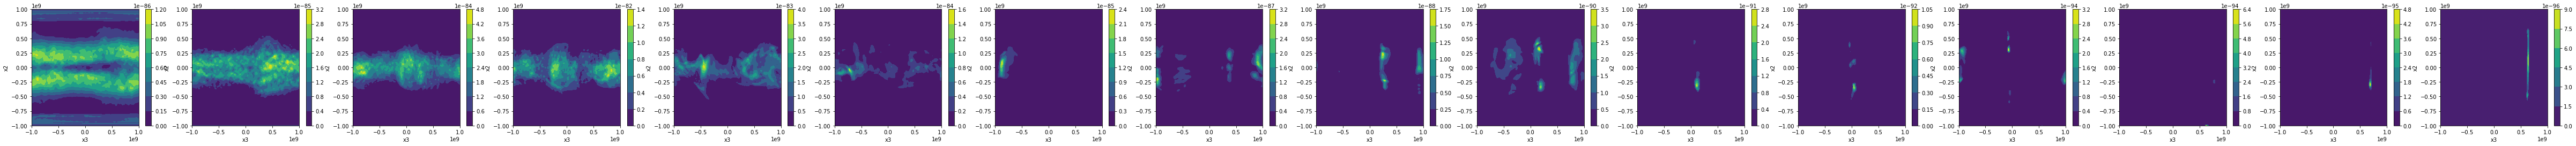

In [20]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_ma, 'avgcoeff3', 'Time Average 2D Contours Plot [MAD, Coeff(Pmag)]', idx=i)
    count +=1
fig.savefig('avg2D_MAD_Rh160_Pmag.png')

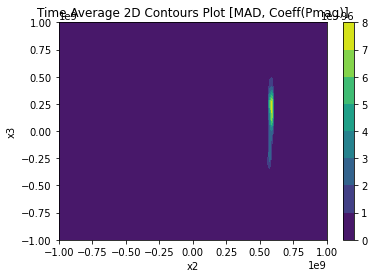

In [23]:
twoD_contour(dumps_ma, 'avgcoeff3', 'Time Average 2D Contours Plot [MAD, Coeff(Pmag)]', idx=287)
plt.savefig('avg2D_MAD_Rh160_Pmag'+ str(287)+'.png')

In [ ]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x2(dumps_ma, 'avgcoeff3', 'Time Average 2D Contours Plot [MAD, Coeff(Pmag)]', idx=i)
    plt.savefig('avg2D_MAD_Rh160_Pmag_x1x2'+ str(i)+'.png')

In [ ]:
for i in range(0, 288):
    print(i)
    twoD_contour_x1x3(dumps_ma, 'avgcoeff3', 'Time Average 2D Contours Plot [MAD, Coeff(Pmag)]', idx=i)
    plt.savefig('avg2D_MAD_Rh160_Pmag_x1x3'+ str(i)+'.png')

### SANE

In [16]:
for dump in dumps_sa.values():
    dump['RHO']

$F_{1}$

In [17]:
for dump in dumps_sa.values():
    F1(dump, R_high[0], R_low)

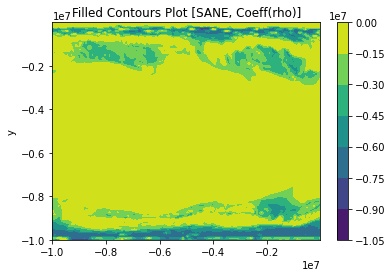

In [19]:
N = 128
x = np.linspace(-1e7, -1e3, N)
y = np.linspace(-1e7, -1e3, N)

X, Y = np.meshgrid(x, y)
z1 = dumps_sa[str(i0)].cache['coeff1'][0]

fig, ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, z1)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot [SANE, Coeff(rho)]')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y')
plt.show()

In [18]:
rho_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff1'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_sa_coeff_avg.values())))

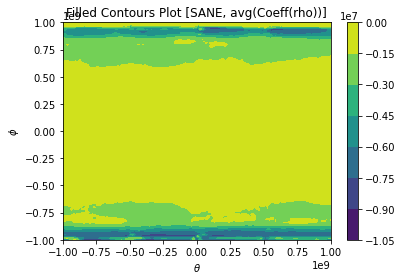

In [21]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]')

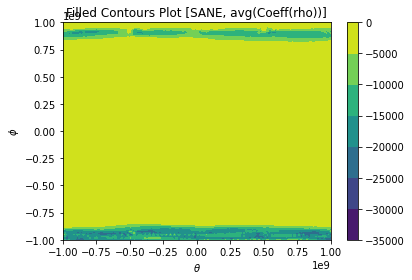

In [20]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]', idx=63)

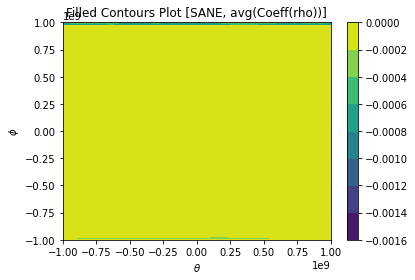

In [21]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]', idx=-1)

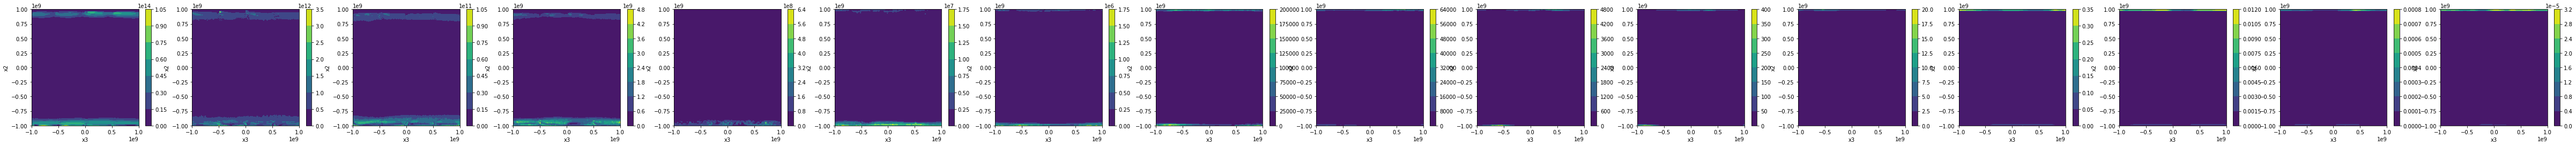

In [20]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_sa, 'avgcoeff1', 'Time Average 2D Contours Plot [SANE, Coeff(rho)]', idx=i)
    count +=1
fig.savefig('avg2D_SANE_Rh1_rho.png')

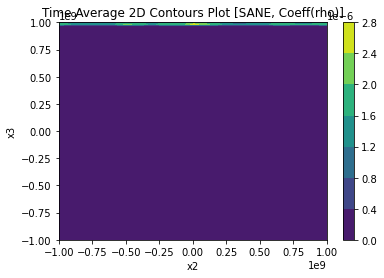

In [21]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Time Average 2D Contours Plot [SANE, Coeff(rho)]', idx=287)
plt.savefig('avg2D_SANE_Rh1_Pmag'+ str(287)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x2(dumps_sa, 'avgcoeff1', 'Time Average 2D Contours Plot [SANE, Coeff(rho)]', idx=i)
    plt.savefig('avg2D_SANE_Rh1_Pmag_x1x2'+ str(i)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x3(dumps_sa, 'avgcoeff1', 'Time Average 2D Contours Plot [SANE, Coeff(rho)]', idx=i)
    plt.savefig('avg2D_SANE_Rh1_rho_x1x3'+ str(i)+'.png')

$F_{2}$

In [17]:
for dump in dumps_sa.values():
    F2(dump, R_high[0], R_low)

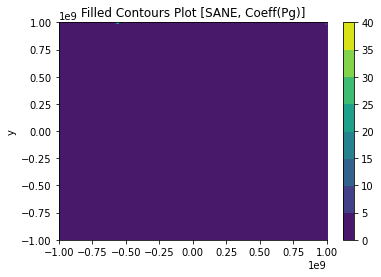

In [20]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]')

In [18]:
Pg_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff2'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_sa_coeff_avg.values())))

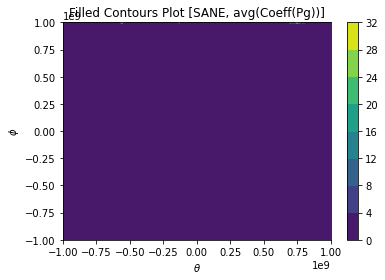

In [20]:
twoD_contour(dumps_sa, 'avgcoeff2', 'Filled Contours Plot [SANE, avg(Coeff(Pg))]')

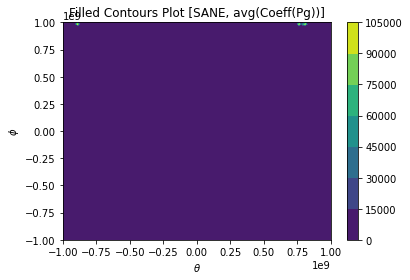

In [20]:
twoD_contour(dumps_sa, 'avgcoeff2', 'Filled Contours Plot [SANE, avg(Coeff(Pg))]', idx=63)

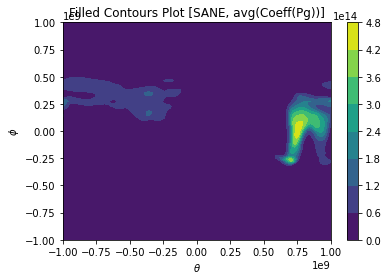

In [22]:
twoD_contour(dumps_sa, 'avgcoeff2', 'Filled Contours Plot [SANE, avg(Coeff(Pg))]', idx=-1)

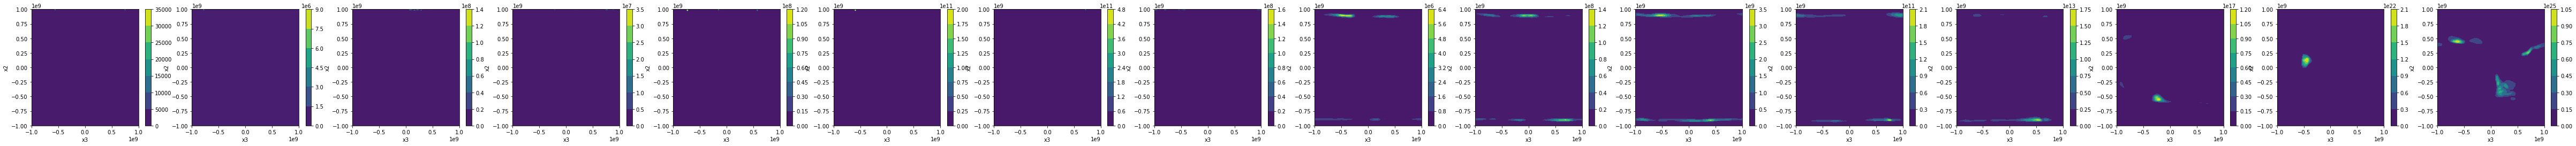

In [20]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_sa, 'avgcoeff2', 'Time Average 2D Contours Plot [SANE, Coeff(Pg)]', idx=i)
    count +=1
fig.savefig('avg2D_SANE_Rh1_Pg.png')

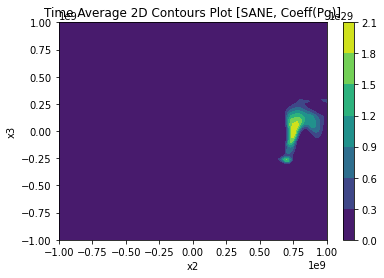

In [21]:
twoD_contour(dumps_sa, 'avgcoeff2', 'Time Average 2D Contours Plot [SANE, Coeff(Pg)]', idx=287)
plt.savefig('avg2D_SANE_Rh1_Pg'+ str(287)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x2(dumps_sa, 'avgcoeff2', 'Time Average 2D Contours Plot [SANE, Coeff(Pg)]', idx=i)
    plt.savefig('avg2D_SANE_Rh1_Pg_x1x2'+ str(i)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x3(dumps_sa, 'avgcoeff2', 'Time Average 2D Contours Plot [SANE, Coeff(Pg)]', idx=i)
    plt.savefig('avg2D_SANE_Rh1_Pg_x1x3'+ str(i)+'.png')

$F_{3}$

In [16]:
for dump in dumps_sa.values():
    F3(dump, R_high[0], R_low)

In [17]:
print(dumps_sa[str(i0)].cache['coeff3'][0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
twoD_contour(dumps_sa, 'coeff3', 'Filled Contours Plot [SANE, Coeff(Pmag)]')

### $R_{high}$=160, $R_{low}$=1

$F_{1}$

In [ ]:
for dump in dumps_sa.values():
    F1(dump, R_high[3], R_low)

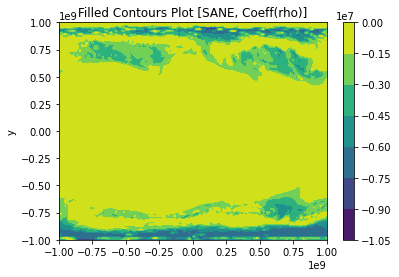

In [20]:
twoD_contour(dumps_sa,'coeff1','Filled Contours Plot [SANE, Coeff(rho)]')

In [18]:
rho_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff1'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff1'] = np.squeeze(np.array(list(rho_sa_coeff_avg.values())))

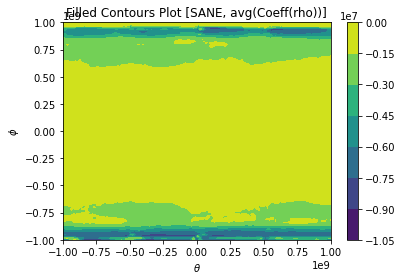

In [21]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]')

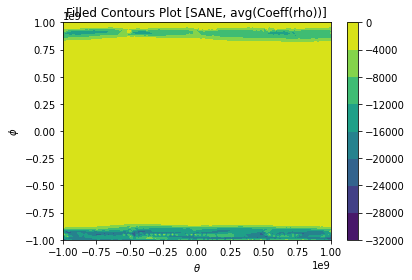

In [22]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]', idx=64)

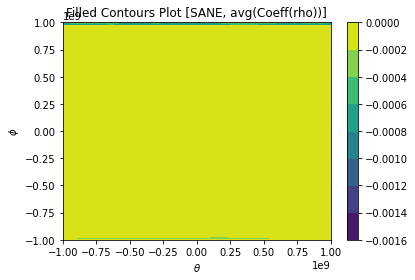

In [23]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Filled Contours Plot [SANE, avg(Coeff(rho))]', idx=-1)

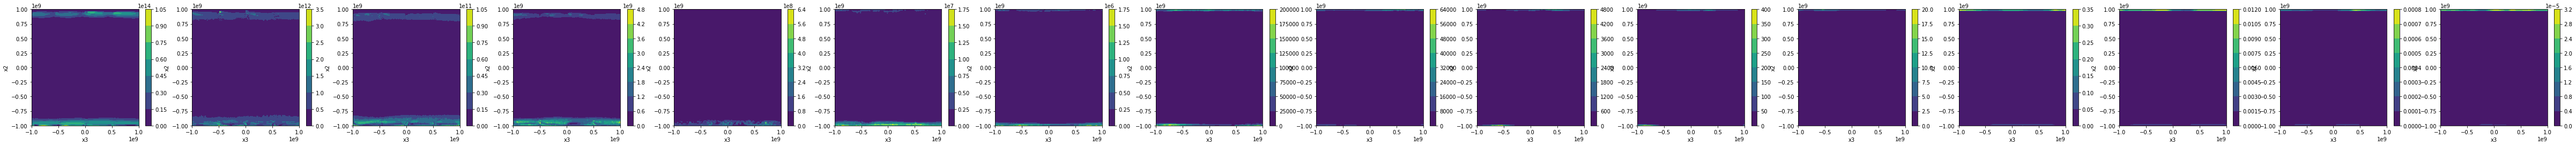

In [20]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_sa, 'avgcoeff1', 'Time Average 2D Contours Plot [SANE, Coeff(rho)]', idx=i)
    count +=1
fig.savefig('avg2D_SANE_Rh160_rho.png')

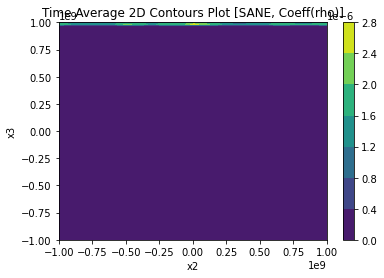

In [20]:
twoD_contour(dumps_sa, 'avgcoeff1', 'Time Average 2D Contours Plot [SANE, Coeff(rho)]', idx=287)
plt.savefig('avg2D_SANE_Rh160_rho_x2x3'+ str(287)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x2(dumps_sa, 'avgcoeff1', 'Time Average 2D Contours Plot [SANE, Coeff(rho)]', idx=i)
    plt.savefig('avg2D_SANE_Rh160_rho_x1x2'+ str(i)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x3(dumps_sa, 'avgcoeff1', 'Time Average 2D Contours Plot [SANE, Coeff(rho)]', idx=i)
    plt.savefig('avg2D_SANE_Rh160_rho_x1x3'+ str(i)+'.png')

$F_{2}$

In [19]:
for dump in dumps_sa.values():
    F2(dump, R_high[3], R_low)

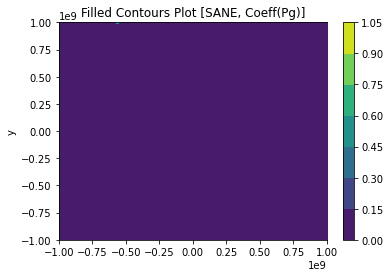

In [18]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]')

In [20]:
Pg_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff2'])

finish average calculation.


In [21]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff2'] = np.squeeze(np.array(list(Pg_sa_coeff_avg.values())))

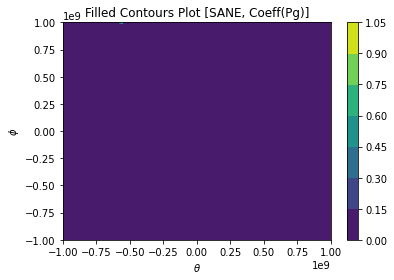

In [25]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', idx=0)

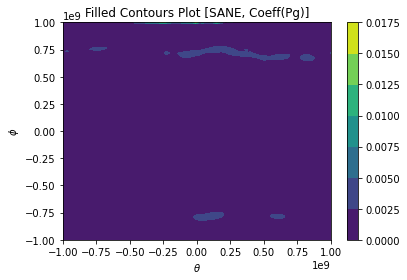

In [26]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', idx=63)

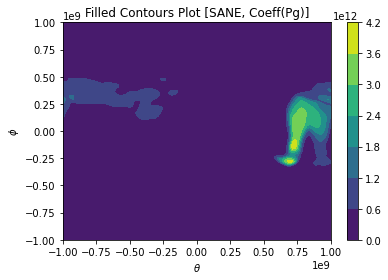

In [27]:
twoD_contour(dumps_sa, 'coeff2', 'Filled Contours Plot [SANE, Coeff(Pg)]', idx=-1)

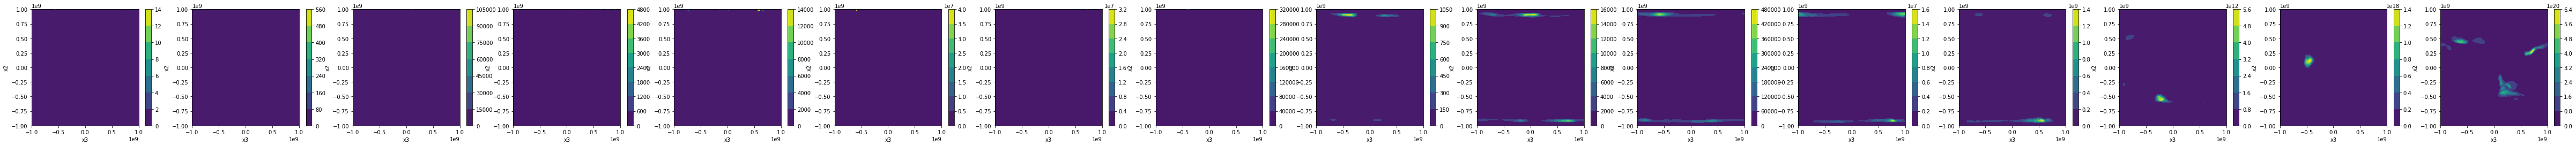

In [22]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_sa, 'avgcoeff2', 'Time Average 2D Contours Plot [SANE, Coeff(Pg)]', idx=i)
    count +=1
fig.savefig('avg2D_SANE_Rh160_Pg.png')

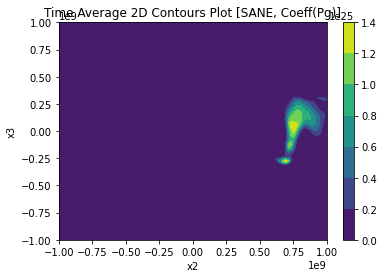

In [20]:
twoD_contour(dumps_sa, 'avgcoeff2', 'Time Average 2D Contours Plot [SANE, Coeff(Pg)]', idx=287)
plt.savefig('avg2D_SANE_Rh160_Pg'+ str(287)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x2(dumps_sa, 'avgcoeff2', 'Time Average 2D Contours Plot [SANE, Coeff(Pg)]', idx=i)
    plt.savefig('avg2D_SANE_Rh160_Pg_x1x2'+ str(i)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x3(dumps_sa, 'avgcoeff2', 'Time Average 2D Contours Plot [SANE, Coeff(Pg)]', idx=i)
    plt.savefig('avg2D_SANE_Rh160_Pg_x1x3'+ str(i)+'.png')

$F_{3}$

In [17]:
for dump in dumps_sa.values():
    F3(dump, R_high[3], R_low)

In [18]:
Pmag_sa_coeff_avg = average(range(i0, i1), dumps_sa, ['coeff3'])

finish average calculation.


In [19]:
for dump in dumps_sa.values():
    dump.cache['avgcoeff3'] = np.squeeze(np.array(list(Pmag_sa_coeff_avg.values())))

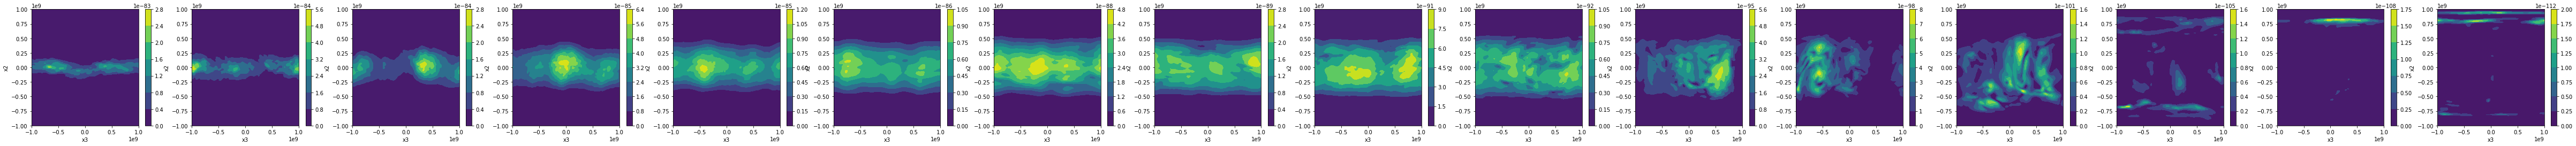

In [20]:
fig,axes = plt.subplots(1,16, figsize=(85, 4))
count = 0
for i in range(0, 288, 18):
    twoD_contour(dumps_sa, 'avgcoeff3', 'Time Average 2D Contours Plot [SANE, Coeff(Pmag)]', idx=i)
    count +=1
fig.savefig('avg2D_SANE_Rh160_Pmag.png')

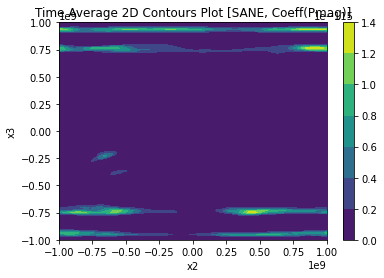

In [21]:
twoD_contour(dumps_sa, 'avgcoeff3', 'Time Average 2D Contours Plot [SANE, Coeff(Pmag)]', idx=287)
plt.savefig('avg2D_SANE_Rh160_Pmag'+ str(287)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x2(dumps_sa, 'avgcoeff3', 'Time Average 2D Contours Plot [SANE, Coeff(Pmag)]', idx=i)
    plt.savefig('avg2D_SANE_Rh160_Pmag_x1x2'+ str(i)+'.png')

In [ ]:
for i in range(0, 288):
    twoD_contour_x1x3(dumps_sa, 'avgcoeff3', 'Time Average 2D Contours Plot [SANE, Coeff(Pmag)]', idx=i)
    plt.savefig('avg2D_SANE_Rh160_Pmag_x1x3'+ str(i)+'.png')